# TODO: Angle aerofoils 

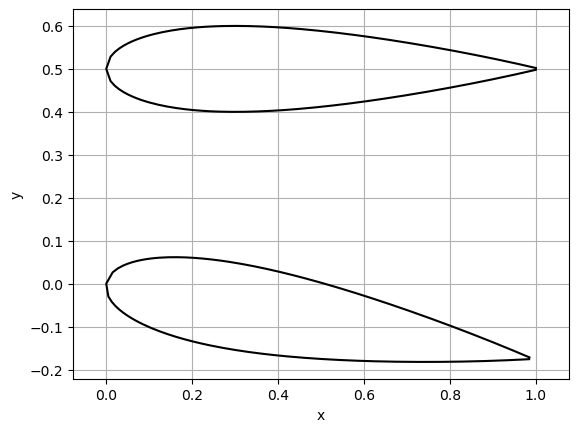

In [5]:
from aerofoil import *
from matplotlib import pyplot as plt

turbine_width = 0.5
foil_width = 0.2
alphas = [-10,0]

# Create a NACA 0012 aerofoil
x,y = naca_foil(foil_width, alpha=alphas[0])
x2,y2 = naca_foil(foil_width, alpha=alphas[1])
y2 = y2 + turbine_width

# x,y = naca_one_side(foil_width,side='left', alpha=alphas[0])
# x2,y2 = naca_one_side(foil_width,side='right', alpha = alphas[1])
# y2 = y2 + turbine_width

# Plot the aerofoil
plt.plot(x,y,'k-')
plt.plot(x2,y2,'k-')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()



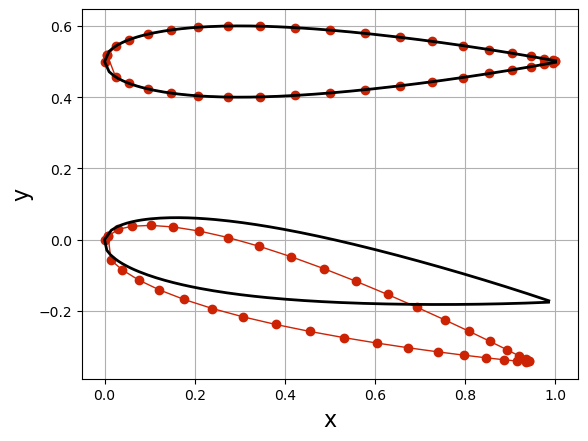

In [6]:
import numpy as np

plt.figure()
aerofoils = np.empty(2, dtype=object)
coords = [[x,y],[x2,y2]]
# coords = [[x,y]]
# discretise the aerofoil into panels
for i,aerofoil in enumerate(coords):
    aerofoils[i] = define_panels(aerofoil[0],aerofoil[1],N=40, alpha=alphas[i])
    for panel in aerofoils[i]:
        panel.rotate_panel(alphas[i])
    plt.plot(np.append([panel.xa for panel in aerofoils[i]], aerofoils[i][0].xa),
            np.append([panel.ya for panel in aerofoils[i]], aerofoils[i][0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
    

plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x, y, color='k', linestyle='-', linewidth=2)
plt.plot(x2, y2, color='k', linestyle='-', linewidth=2)




In [7]:
# define the freestream conditions
u_inf = 1.0
alpha = -5
freestream_1 = Freestream(u_inf, alpha)
freestream_2 = Freestream(u_inf, -alpha)
freestreams = [freestream_1, freestream_2]

In [8]:
for i,p in enumerate(aerofoils):  
    A = A_mat(p)
    b = b_vec(p, freestreams[i])

    # solve the linear system
    variables = np.linalg.solve(A, b)

    # store the source strength on each panel
    for ii, panel in enumerate(p):
        panel.sigma = variables[ii]

    # get tangential velocity at each panel center-point
    tan_vel(p, freestreams[i])
    # get pressure coefficient at each panel center-point
    cp(p, freestreams[i])

/Users/philblecher/Desktop/Github/DP5-code/aerofoil.py:189: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(integrand, 0.0, panel.length)[0]


Text(0, 0.5, 'y')

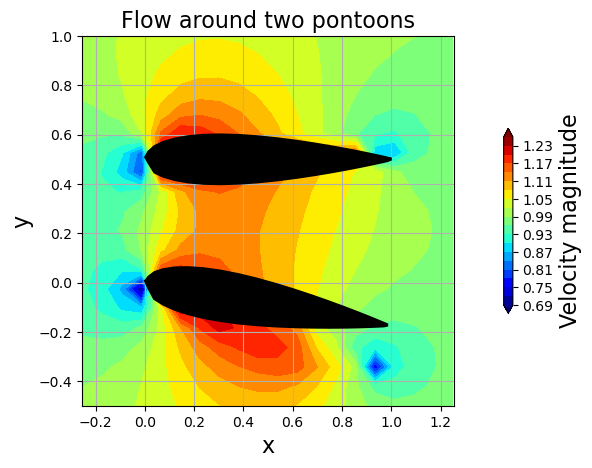

In [9]:
# define velocity field
nx, ny = 20, 20
x_start, x_end = -0.25, 1.25
y_start, y_end = -0.5, 1
x = np.linspace(x_start, x_end, nx)
y = np.linspace(y_start, y_end, ny)
X, Y = np.meshgrid(x, y)

plt.figure()
plt.axis('equal')
# compute the velocity field on the mesh grid
u_tot = np.zeros((ny, nx))
v_tot = np.zeros((ny, nx))
for i,panels in enumerate(aerofoils):
    u, v = vel_field(panels, freestreams[i], X, Y)
    u_tot += u
    v_tot += v

# normalize the velocity field
u_tot /= 2 * u_inf
v_tot /= 2 * u_inf

# # plot the velocity field  
# plt.streamplot(X, Y, u_tot, v_tot, density=2, linewidth=1, arrowsize=1, arrowstyle='->')

for panels in aerofoils:
    plt.fill([panel.xc for panel in panels],
        [panel.yc for panel in panels],
        color='k', linestyle='solid', linewidth=2, zorder=2)
    
# add contours of velocity
plt.contourf(X, Y, np.sqrt(u_tot**2 + v_tot**2), extend='both', cmap='jet', levels=20)

cbar = plt.colorbar(orientation='vertical', shrink=0.5, pad=0.1)
cbar.set_label('Velocity magnitude', fontsize=16)

plt.grid()
plt.title('Flow around two pontoons', fontsize=16)
plt.xlim(x_start, x_end)
plt.ylim(y_start, y_end)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)

# mark the maximum velocity with a number
